# Calibration Plotting


May 17th, 2024
Neerja Aggarwal
Plot the spectral calibration data nicely

In [1]:
from cleanplots import *

import numpy as np
import os
import sys
sys.path.append("/home/emarkley/Workspace/PYTHON/spectraldiffuserscope/ReconCode") # needed to bring in sdc module
import sdc_jax as sdc

import jax.numpy as jnp
import jax
# figures helper functions
%run figures_util.py
# from cleanplots import *

# CHOOSE GPU
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../')
gpu = 0

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #stop jax from preallocating 75% of the gpu

In [2]:
# Load and crop filter cube
calibration_location = '../'
psf_name = '/home/emarkley/Workspace/PYTHON/spectraldiffuserscope/recon_materials_organized/psf_2023-11-16.npy'
filter_cube_file = '/home/emarkley/Workspace/PYTHON/spectraldiffuserscope/recon_materials_organized/spectral_filter_2024-02-23.npy'  # 'filter_stack' # use new one from 2024
wv_file = '/home/emarkley/Workspace/PYTHON/spectraldiffuserscope/recon_materials_organized/wavelengths_2024-02-23.npy'
filter_stack = np.load(os.path.join(calibration_location, filter_cube_file))
wavelength = np.load(os.path.join(calibration_location, wv_file))

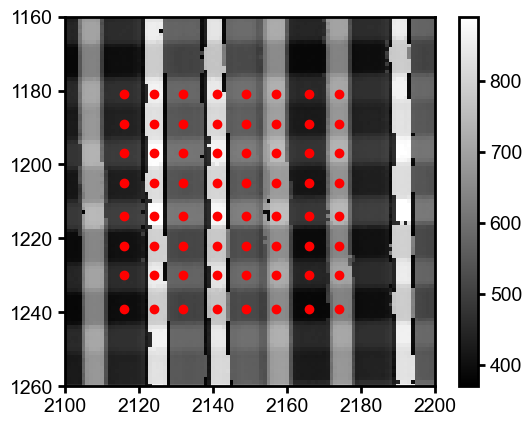

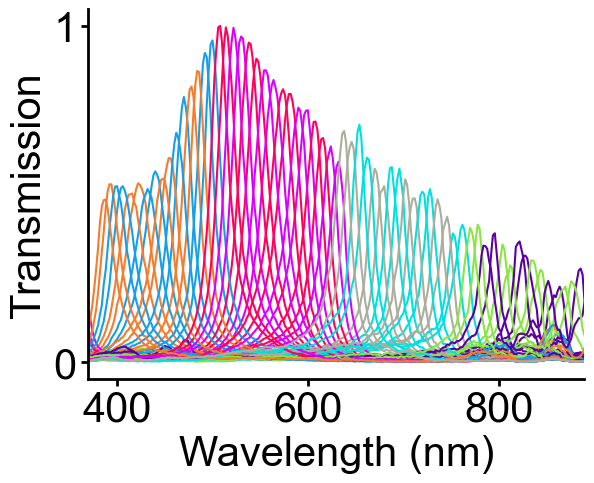

In [3]:
maxes = np.argmax(filter_stack, axis = 0)
idy,idx= [1181,2116]
pixsize = 2.4 # micron
filtersize = 20 # micron
stride = filtersize/pixsize
yval = np.floor(np.arange(idy,idy+stride*8, stride))[0:8].astype('int')
xval = np.floor(np.arange(idx,idx+stride*8, stride))[0:8].astype('int')
x,y = np.meshgrid(xval,yval)
plt.scatter(x,y, c = 'red')
# plt.imshow(filter_stack[100,:,:])
plt.imshow(wavelength[maxes], cmap = 'grey')
plt.colorbar()
plt.xlim(2100,2200)
plt.ylim(1260,1160)

filter_transmission = filter_stack[:,y,x].reshape(len(wavelength),len(y)*len(x))
# make into pretty transmission plot. 
filter_transmission = filter_transmission/np.max(filter_transmission)
plt.figure()
plt.plot(wavelength,filter_transmission)

plt.xlabel('Wavelength (nm)',  fontsize=30)
plt.ylabel('Transmission',  fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([370,890])

# Set the x-axis tick locations
plt.gca().set_xticks([400,600,800])
plt.gca().set_yticks([0,1])

In [4]:
# make into rainbow.
# sort into ascending peaks

from scipy.signal import find_peaks
peak_list = []
# Find the peaks in the filter_transmission data
for k in range(filter_transmission.shape[1]):
    peaks, _ = find_peaks(filter_transmission[:,k], prominence=0.05)
    if len(peaks)==0:
        print(k)
    if len(peaks)>1:
        print(k)
    peak_list.append(peaks[0])
# sort into ascending peaks
sort_idx = np.squeeze(np.argsort([peak_list]))
print(sort_idx)
filter_transmission_sorted = filter_transmission[:,sort_idx]



8
14
24
30
40
[62 46 56 40 30 14 24  8 54  6 48  0 33 22 38 16 32 58 42 60 44 26 10 28
 12 50  2 52  4 18 34 20 36 63 47 61 45 31 15 29 13 55  7 53  5 23 39 21
 37 59 43 57 41 27 11 25  9 51  3 49  1 19 35 17]


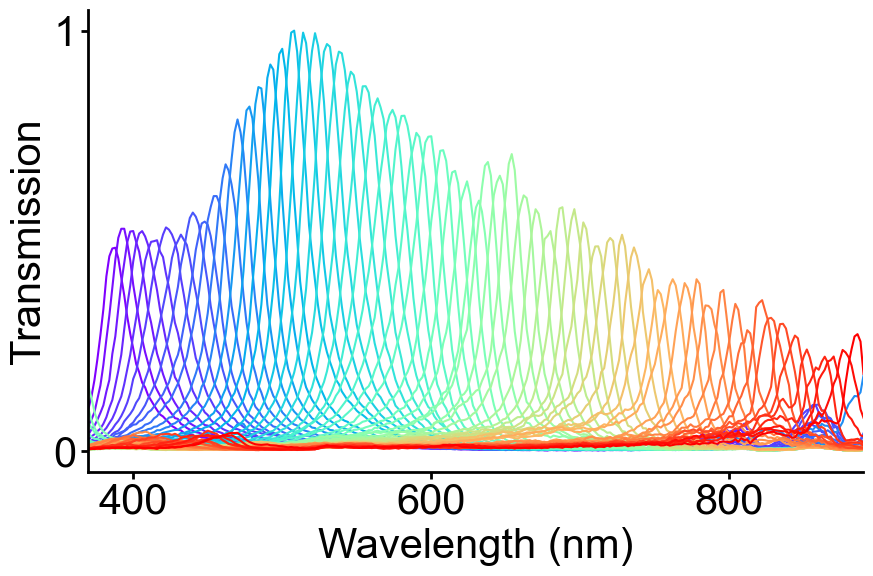

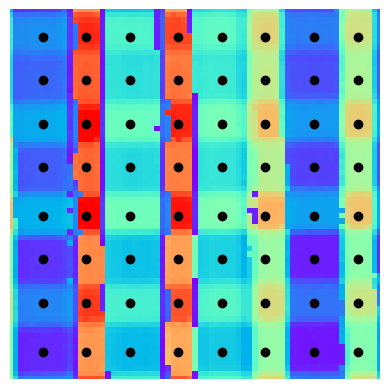

In [5]:

# Create a colormap with rainbow colors
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, filter_transmission.shape[1]))

# Plot the data
plt.figure(figsize=(10, 6))

for i in range(filter_transmission.shape[1]):
    plt.plot(wavelength,filter_transmission_sorted[:,i], color=colors[i,:])

plt.xlabel('Wavelength (nm)',  fontsize=30)
plt.ylabel('Transmission',  fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([370,890])

# Set the x-axis tick locations
plt.gca().set_xticks([400,600,800])
plt.gca().set_yticks([0,1])
plt.savefig('filter_response.svg', format='svg')
plt.show()


plt.figure()
idy,idx= [1181,2116]
pixsize = 2.4 # micron
filtersize = 20 # micron
stride = filtersize/pixsize
yval = np.floor(np.arange(idy,idy+stride*8, stride))[0:8].astype('int')
xval = np.floor(np.arange(idx,idx+stride*8, stride))[0:8].astype('int')
x,y = np.meshgrid(xval,yval)
plt.scatter(x,y, c = 'black', marker = 'o')
# plt.imshow(filter_stack[100,:,:])
plt.imshow(wavelength[maxes], cmap = cmap)
# plt.colorbar()
plt.xlim(2110,2178)
plt.ylim(1244,1176)
plt.axis('off')
plt.savefig('superpixel.svg', format='svg')
plt.show()


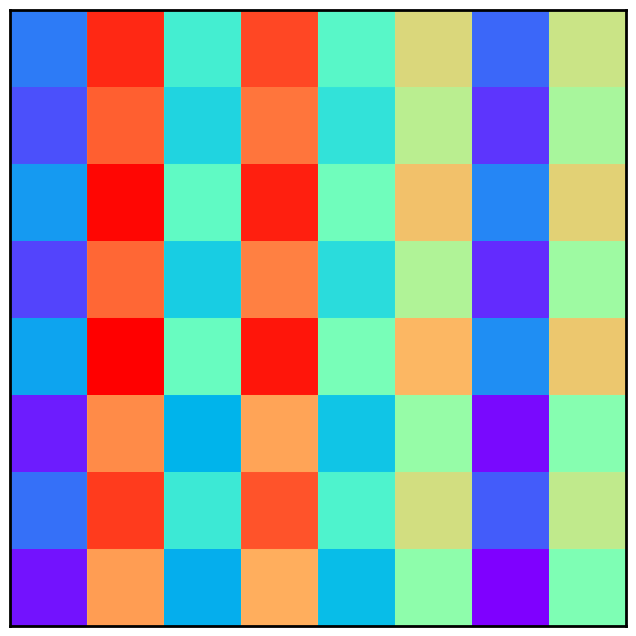

In [11]:
# ... existing code ...

# Create synthetic filter using the sorted transmission data
import torch
import torchvision

# Convert numpy arrays to torch tensors
wavelength_torch = torch.from_numpy(wavelength)
filter_transmission_torch = torch.from_numpy(filter_transmission)

filter_size = 64
sensor_size = torch.tensor((2048, 3072))
super_pixel = torch.zeros((len(wavelength), 8*filter_size, 8*filter_size))
count = 0

# Create the super pixel pattern using the sorted filter transmissions
for ii in range(8):
    for jj in range(8):
        if count < filter_transmission_torch.shape[1]:  # Make sure we don't exceed number of filters
            super_pixel[:, ii*filter_size:(ii+1)*filter_size, 
                          jj*filter_size:(jj+1)*filter_size] = (
                torch.ones((1, filter_size, filter_size)) * 
                filter_transmission_torch[:, count].unsqueeze(-1).unsqueeze(-1)
            )
            count += 1

# Visualize the wavelength response pattern
plt.figure(figsize=(10, 8))
peak_wavelength = wavelength[0] + torch.argmax(super_pixel, dim=0) * (wavelength[1] - wavelength[0])
plt.imshow(peak_wavelength, cmap=cmap)
# plt.colorbar(label='Wavelength (nm)')
plt.xticks([])
plt.yticks([])
# plt.title('Peak Wavelength Response')
plt.savefig('superpixel_synthetic.svg', format='svg')
plt.show()

NameError: name 'sdc_np' is not defined

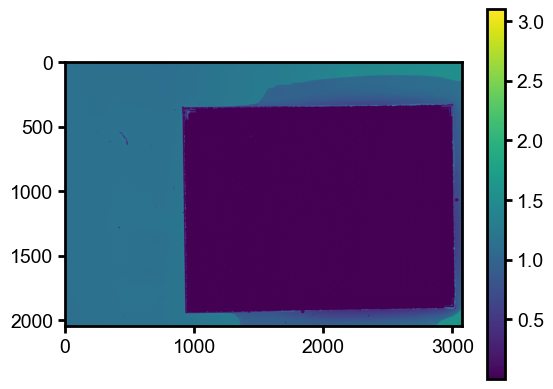

In [6]:
plt.imshow(filter_stack[0,:,:])
plt.colorbar()

HSI_data = np.transpose(filter_stack, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,filter_stack.shape[0]])
false_color = sdc_np.HSI2RGB(wavelength, HSI_data ,filter_stack.shape[1],filter_stack.shape[2], 65, False)
plt.imshow(false_color)


(-0.5, 65.5, 65.5, -0.5)

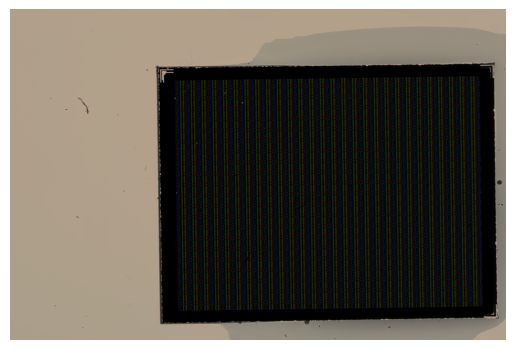

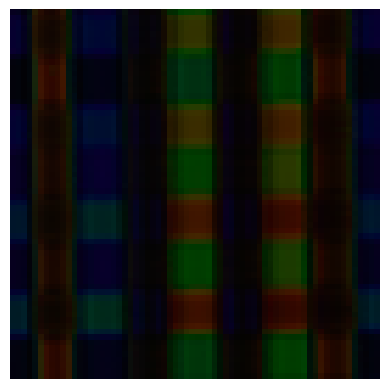

In [54]:
plt.figure()
plt.imshow(false_color)
plt.axis('off')
plt.figure()
plt.imshow(false_color[1160:1160+66,2100:2100+66,:])
plt.axis('off')
